In [13]:
import folium
from folium.plugins import MarkerCluster
# pip install meteostat tqdm joblib
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
from meteostat import Hourly, Point
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from tqdm import tqdm


In [1]:
tqdm.pandas()

# 1. Load crime dataset in chunks with safe datetime parsing
chunk_list = []
for chunk in pd.read_csv("Crimes_-_2001_to_Present_20250410.csv", chunksize=500_000, low_memory=False):
    try:
        chunk['Date'] = pd.to_datetime(chunk['Date'], format='%m/%d/%Y %H:%M', errors='raise')
    except Exception:
        chunk['Date'] = pd.to_datetime(chunk['Date'], errors='coerce')  # fallback to flexible parsing

    chunk = chunk[['Date', 'Arrest', 'Latitude', 'Longitude', 'Community Area']]
    chunk.dropna(subset=['Date', 'Latitude', 'Longitude'], inplace=True)
    chunk['DateHour'] = chunk['Date'].dt.floor('h')
    chunk['LatGrid'] = chunk['Latitude'].round(2)
    chunk['LonGrid'] = chunk['Longitude'].round(2)
    chunk_list.append(chunk)

crime_df = pd.concat(chunk_list, ignore_index=True)


In [11]:
# Save cleaned data as reference for later use

crime_df.to_pickle("df_reference.pkl")
print("Cleaned reference dataset saved as df_reference.pkl")

Cleaned reference dataset saved as df_reference.pkl


In [3]:

# 2. Batch location-hour grid creation to avoid memory error
locations = crime_df[['LatGrid', 'LonGrid']].drop_duplicates()
time_range = pd.date_range(start=crime_df['DateHour'].min(), end=crime_df['DateHour'].max(), freq='h')
all_dfs = []
# Break location grid into manageable chunks
location_batches = np.array_split(locations, 100)
for i, loc_batch in enumerate(location_batches):
    print(f"Processing batch {i+1}/{len(location_batches)}")
    # Reduce date range per batch to 100-hour rolling window
    
    # date_window = time_range[(i*100)%len(time_range):(i*100+100)%len(time_range)]
    chunk_size = 100
    start = i * chunk_size
    end = min(start + chunk_size, len(time_range))
    date_window = time_range[start:end]

    
    if len(date_window) == 0:
        continue
    grids = pd.MultiIndex.from_product([date_window, loc_batch['LatGrid'], loc_batch['LonGrid']], names=['DateHour', 'LatGrid', 'LonGrid'])
    batch_df = pd.DataFrame(index=grids).reset_index()
    all_dfs.append(batch_df)

# Combine batches into single DataFrame
df = pd.concat(all_dfs, ignore_index=True)

# 3. Pull weather data
station = Point(41.9742, -87.9073)
weather_df = Hourly(station, time_range.min(), time_range.max()).fetch().reset_index()
weather_df['DateHour'] = weather_df['time'].dt.floor('h')
df = df.merge(weather_df, on='DateHour', how='left')

# Fill missing weather data using forward and backward fill
weather_cols = ['temp', 'rhum', 'prcp', 'snow', 'wspd']
df[weather_cols] = df[weather_cols].ffill().bfill()
df = df[(df['temp'] > -50) & (df['temp'] < 60)]

# 4. Add time-based features
df['Hour'] = df['DateHour'].dt.hour
df['DayOfWeek'] = df['DateHour'].dt.dayofweek
df['Month'] = df['DateHour'].dt.month
df['IsWeekend'] = df['DayOfWeek'].isin([5, 6]).astype(int)

# 5. Label crime occurrences
crime_keys = set(zip(crime_df['DateHour'], crime_df['LatGrid'], crime_df['LonGrid']))
df['CrimeOccurred'] = df.apply(lambda row: (row['DateHour'], row['LatGrid'], row['LonGrid']) in crime_keys, axis=1).astype(int)

print("Class distribution:")
print(df['CrimeOccurred'].value_counts())

⏳ Processing batch 1/100
⏳ Processing batch 2/100
⏳ Processing batch 3/100
⏳ Processing batch 4/100
⏳ Processing batch 5/100
⏳ Processing batch 6/100
⏳ Processing batch 7/100
⏳ Processing batch 8/100
⏳ Processing batch 9/100
⏳ Processing batch 10/100
⏳ Processing batch 11/100
⏳ Processing batch 12/100
⏳ Processing batch 13/100
⏳ Processing batch 14/100
⏳ Processing batch 15/100
⏳ Processing batch 16/100
⏳ Processing batch 17/100
⏳ Processing batch 18/100
⏳ Processing batch 19/100
⏳ Processing batch 20/100
⏳ Processing batch 21/100
⏳ Processing batch 22/100
⏳ Processing batch 23/100
⏳ Processing batch 24/100
⏳ Processing batch 25/100
⏳ Processing batch 26/100
⏳ Processing batch 27/100
⏳ Processing batch 28/100
⏳ Processing batch 29/100
⏳ Processing batch 30/100
⏳ Processing batch 31/100
⏳ Processing batch 32/100
⏳ Processing batch 33/100
⏳ Processing batch 34/100
⏳ Processing batch 35/100
⏳ Processing batch 36/100
⏳ Processing batch 37/100
⏳ Processing batch 38/100
⏳ Processing batch 39

Class distribution:
CrimeOccurred
0    529782
1     30718
Name: count, dtype: int64


In [4]:
# 6. Arrest signals using vectorized aggregation

crime_df_arrests = crime_df[crime_df['Arrest'] == True].copy()
arrests_grouped = crime_df_arrests.groupby(['LatGrid', 'LonGrid', 'DateHour']).size().reset_index(name='ArrestCount')
df = df.sort_values(['LatGrid', 'LonGrid', 'DateHour'])
arrests_grouped = arrests_grouped.sort_values(['LatGrid', 'LonGrid', 'DateHour'])

df = df.merge(arrests_grouped, on=['DateHour', 'LatGrid', 'LonGrid'], how='left')
df['ArrestCount'] = df['ArrestCount'].fillna(0)
df['RecentArrests'] = df.groupby(['LatGrid', 'LonGrid'])['ArrestCount'].transform(lambda x: x.rolling(window=168, min_periods=1).sum())
df['RepeatOffenderSignal'] = df.groupby(['LatGrid', 'LonGrid'])['ArrestCount'].transform(lambda x: x.rolling(window=720, min_periods=1).sum())

In [5]:
# 7. Final feature check with verbose report

features = [
    'Hour', 'DayOfWeek', 'Month', 'IsWeekend',
    'temp', 'rhum', 'prcp', 'snow', 'wspd',
    'RecentArrests', 'RepeatOffenderSignal'
]

features = [f for f in features if df[f].notna().sum() > 0]
print("Features retained for model:", features)

df[features] = df[features].ffill().bfill()
df = df.dropna(subset=features)
print("Remaining rows after cleaning:", df.shape)

if df.empty:
    raise ValueError("Dataframe is empty after cleaning. Try checking weather coverage or use a narrower date range.")


Features retained for model: ['Hour', 'DayOfWeek', 'Month', 'IsWeekend', 'temp', 'rhum', 'prcp', 'wspd', 'RecentArrests', 'RepeatOffenderSignal']
Remaining rows after cleaning: (560500, 23)


In [6]:
# 8. Train model

X = df[features]
y = df['CrimeOccurred']

if len(y.unique()) < 2:
    raise ValueError("Only one class present. Not enough variability to train.")

print(f"Proceeding with full dataset: {len(y)} records")
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.25, random_state=42)
import multiprocessing
n_cores = multiprocessing.cpu_count()
clf = RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42, n_jobs=n_cores)
clf.fit(X_train, y_train)
joblib.dump(clf, "crime_predictor_model.pkl")

Proceeding with full dataset: 560500 records


['crime_predictor_model.pkl']

              precision    recall  f1-score   support

           0       0.96      0.96      0.96    132446
           1       0.32      0.32      0.32      7679

    accuracy                           0.93    140125
   macro avg       0.64      0.64      0.64    140125
weighted avg       0.93      0.93      0.93    140125

ROC-AUC Score: 0.8308749612117005


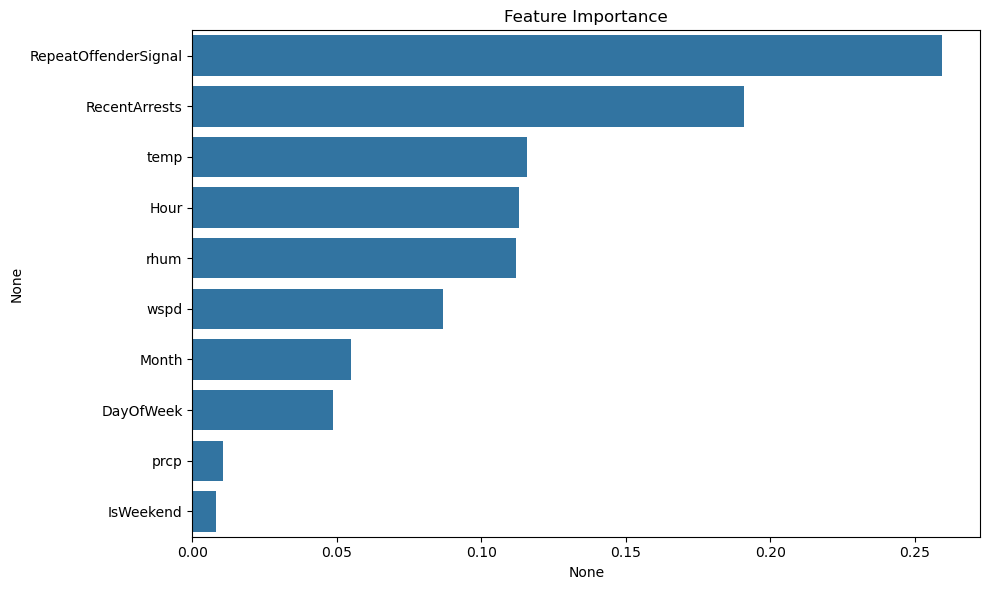

In [7]:
# 9. Evaluation

y_pred = clf.predict(X_test)
y_proba = clf.predict_proba(X_test)[:, -1]
print(classification_report(y_test, y_pred, zero_division=0))
try:
    print("ROC-AUC Score:", roc_auc_score(y_test, y_proba))
except ValueError as e:
    print("ROC-AUC could not be computed:", e)

feat_imp = pd.Series(clf.feature_importances_, index=features).sort_values(ascending=False)
plt.figure(figsize=(10, 6))
sns.barplot(x=feat_imp, y=feat_imp.index)
plt.title("Feature Importance")
plt.tight_layout()
plt.show()

In [10]:
# 10. Predict crimes for the next 12 hours from last hour in dataset

print("Predicting next 12 hours of potential crimes...")
last_hour = df['DateHour'].max()
future_hours = pd.date_range(start=last_hour + pd.Timedelta(hours=1), periods=12, freq='h')

# Limit to 100 random locations for memory safety
sampled_locations = locations.sample(n=100, random_state=42)

forecast_grid = pd.MultiIndex.from_product(
    [future_hours, sampled_locations['LatGrid'], sampled_locations['LonGrid']],
    names=['DateHour', 'LatGrid', 'LonGrid']
)
forecast_df = pd.DataFrame(index=forecast_grid).reset_index()


forecast_df['Hour'] = forecast_df['DateHour'].dt.hour
forecast_df['DayOfWeek'] = forecast_df['DateHour'].dt.dayofweek
forecast_df['Month'] = forecast_df['DateHour'].dt.month
forecast_df['IsWeekend'] = forecast_df['DayOfWeek'].isin([5, 6]).astype(int)

latest_weather = df[df['DateHour'] == last_hour][weather_cols].mean()
for col in weather_cols:
    base_val = latest_weather[col]
    if pd.isna(base_val):
        base_val = 0  # fallback in case of all-NaN
    forecast_df[col] = np.full(len(forecast_df), base_val, dtype=np.float32) + np.random.normal(0, 0.1, size=len(forecast_df)).astype(np.float32)

hot_locations = df[df['CrimeOccurred'] == 1].groupby(['LatGrid', 'LonGrid']).size().reset_index(name='crime_count')
forecast_df = forecast_df.merge(hot_locations, on=['LatGrid', 'LonGrid'], how='left')
forecast_df['crime_count'] = forecast_df['crime_count'].fillna(0)
forecast_df['RecentArrests'] = forecast_df['crime_count'] * np.random.uniform(0.1, 0.5)
forecast_df['RepeatOffenderSignal'] = forecast_df['crime_count'] * np.random.uniform(0.3, 1.2)

forecast_X = forecast_df[features]
forecast_df['PredictedCrimeProb'] = clf.predict_proba(forecast_X)[:, -1]
top_preds = forecast_df.sort_values('PredictedCrimeProb', ascending=False).head(10)
print(top_preds.reset_index(drop=True)[['DateHour', 'LatGrid', 'LonGrid', 'PredictedCrimeProb']])



Predicting next 12 hours of potential crimes...
             DateHour  LatGrid  LonGrid  PredictedCrimeProb
0 2002-02-21 23:00:00    41.68   -87.72            0.538413
1 2002-02-21 23:00:00    41.98   -87.74            0.538413
2 2002-02-21 23:00:00    41.98   -87.82            0.538413
3 2002-02-21 23:00:00    41.68   -87.72            0.538413
4 2002-02-21 23:00:00    41.97   -87.79            0.538413
5 2002-02-21 23:00:00    41.68   -87.72            0.538413
6 2002-02-21 23:00:00    41.98   -87.72            0.538413
7 2002-02-21 23:00:00    41.98   -87.72            0.538413
8 2002-02-21 23:00:00    41.98   -87.74            0.538413
9 2002-02-21 23:00:00    41.98   -87.72            0.538413


In [15]:
# 11. Map visualization

# Create a base map centered around the average of top predictions
avg_lat = top_preds['LatGrid'].mean()
avg_lon = top_preds['LonGrid'].mean()
m = folium.Map(location=[avg_lat, avg_lon], zoom_start=12)

# Add predicted crime locations to the map
marker_cluster = MarkerCluster().add_to(m)

for _, row in top_preds.iterrows():
    folium.CircleMarker(
        location=[row['LatGrid'], row['LonGrid']],
        radius=7,
        popup=f"{row['DateHour']}<br>Prob: {row['PredictedCrimeProb']:.2f}",
        color='red',
        fill=True,
        fill_opacity=0.6
    ).add_to(marker_cluster)

m